### Evaluation Results of Experiments that started from different initial state distributions

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Helper function to read evaluation result files
def process_eval_file(file_name:str):
    
    try:
        eva_results = pd.read_excel(f'{file_name}.xlsx')
    except:
        return None
    
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR.replace('[',''), axis=1)
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR_processed.replace(']',''), axis=1)
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR_processed.split(','), axis=1)

    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record.replace('[',''), axis=1)
    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record_processed.replace(']',''), axis=1)
    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record_processed.split(','), axis=1)

    return eva_results

In [34]:
# Import the data
name_prefix_l_skewed =  'experiment_runs\eval_results\original_experiment_results_left_skewed'
name_prefix_r_skewed =  'experiment_runs\eval_results\original_experiment_results_right_skewed'
name_prefix_unbiased =  'experiment_runs\eval_results\original_experiment_results_unbiased'

eval_l_skewed =process_eval_file(name_prefix_l_skewed)
eval_r_skewed =process_eval_file(name_prefix_r_skewed)
eval_unbiased =process_eval_file(name_prefix_unbiased)

n_experiments = eval_unbiased.shape[0]

In [35]:
# Function to compute the `actions vs. cummulative SR` values to be plotted.
def compute_cumm_sr_vals(df):

    tot_exp_original = df.shape[0]
    df.loc[:,'positive_SR_idx'] = df.apply(lambda row: [idx for idx,val in enumerate(row.SR_processed) if float(val)>0], axis=1)
    df.positive_SR_idx = df.positive_SR_idx.apply(lambda cell: np.nan if len(cell)==0 else cell)
    df.dropna(subset=['positive_SR_idx'],inplace=True)

    # In case none of the experiments have found a sufficient policy
    if df.shape[0]==0:
        print('None of the experiments have found a sufficient policy!')
        action_sr_pairs_original_df = pd.DataFrame({'actions':0
                                                            , 'sr': 0
                                                            , 'pct_sr': 0
                                                            ,  'cum_pct_sr': 0}, index = [0])
        return  action_sr_pairs_original_df

    df.loc[:, 'action_SR_pairs'] = df.apply(lambda row: [(int(row.action_record_processed[val]), round(float(row.SR_processed[val]),4)) for val in row.positive_SR_idx ] , axis=1)

    # only select the first action count (if multiple SR-action pairs available)
    df.action_SR_pairs = df.action_SR_pairs.apply(lambda cell: [cell[0]])

    action_sr_pair_list_original = []
    for experiment in df.action_SR_pairs.values:
        for action_sr_pair in experiment:
            action_sr_pair_list_original.append(action_sr_pair)
            
    action_sr_pairs_original = np.array(action_sr_pair_list_original)

    action_sr_pairs_original_df = pd.DataFrame(action_sr_pairs_original)
    action_sr_pairs_original_df.columns = ['actions','sr']
    action_sr_pairs_original_df.sort_values('actions',inplace=True)

    action_sr_pairs_original_df.loc[:,'pct_sr'] = 1/ tot_exp_original

    action_sr_pairs_original_df.loc[:,'cum_pct_sr']  = action_sr_pairs_original_df.pct_sr.cumsum()
    return action_sr_pairs_original_df

In [36]:
# Generate data for the plots
plot_r_skew_data = compute_cumm_sr_vals(eval_r_skewed)
plot_l_skew_data = compute_cumm_sr_vals(eval_l_skewed)
plot_unbiased_data = compute_cumm_sr_vals(eval_unbiased)

None of the experiments have found a sufficient policy!
None of the experiments have found a sufficient policy!


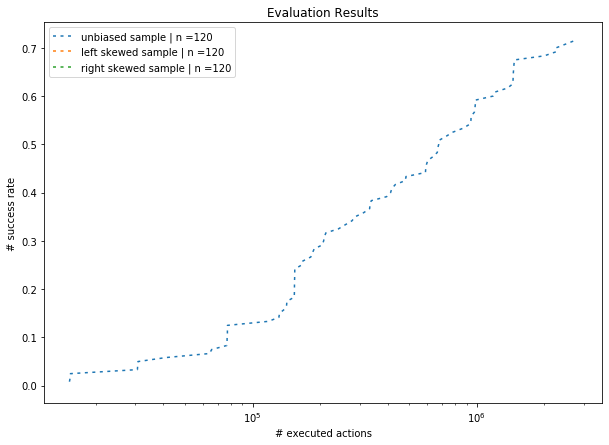

In [37]:
# Create the plots
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(plot_unbiased_data.actions
        , plot_unbiased_data.cum_pct_sr
        , linestyle=':'
        , dashes=(2, 3)
        , label = f'unbiased sample | n ={str(n_experiments)}')

ax.plot(plot_l_skew_data.actions
        , plot_l_skew_data.cum_pct_sr
        , linestyle=':'
        , dashes=(2, 3)
        , label = f'left skewed sample | n ={str(n_experiments)}')

ax.plot(plot_r_skew_data.actions
        , plot_r_skew_data.cum_pct_sr
        , linestyle=':'
        , dashes=(2, 3)
        , label = f'right skewed sample | n ={str(n_experiments)}')


plt.ylabel('# success rate')
plt.xlabel('# executed actions')
plt.title('Evaluation Results')
plt.legend(loc = 'upper left')
plt.xscale('log')
plt.show()

#### Conclusion:

- We can see that, none of the experiments that started from the skewed initial state distributions (both left and right skewed) found a sufficient policy.
- However, 70% of the experiments that started from the unbiased initial state distribution found a sufficient policy.
- This clearly demonstrate that the initial state distribution highly influence the performance of the algorithm.